In [1]:
import sys
print(sys.path)
sys.path.append('/home/upflo/.local/lib/python3.6/site-packages')

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/upflo/fakultet/psz/venv/lib/python3.6/site-packages', '/home/upflo/fakultet/psz/venv/lib/python3.6/site-packages/IPython/extensions', '/home/upflo/.ipython']


In [2]:
df = pd.read_csv('./podaci/ready_data_odbrana.csv', lineterminator='\n', header='infer')

In [3]:
df.head()

,cena,povrsina,grejanje,spratnost,infrastruktura,udaljenost_od_centra
0,2000.0,50.0,grejanje na struju,prizemlje,nema,3.481600
1,275000.0,162.0,etažno grejanje,3,ima,4.063796
2,270000.0,105.0,centralno grejanje,3,ima,1.526104
3,610000.0,153.0,podno grejanje,1,ima,2.779669
4,193000.0,72.0,TA peć,5,ima,0.430149


## Grupisanje ciljanje promenljive - cena (primprema za Knn klasifikaciju)

In [4]:
bins = [0, 50000, 100000, 150000, 200000, np.inf]
labels=['<50', '50-100', '100-150', '150-200', '>200']
df.cena = pd.cut(df['cena'], bins=bins, labels=labels)

In [5]:
df.head()

,cena,povrsina,grejanje,spratnost,infrastruktura,udaljenost_od_centra
0,<50,50.0,grejanje na struju,prizemlje,nema,3.481600
1,>200,162.0,etažno grejanje,3,ima,4.063796
2,>200,105.0,centralno grejanje,3,ima,1.526104
3,>200,153.0,podno grejanje,1,ima,2.779669
4,150-200,72.0,TA peć,5,ima,0.430149


<AxesSubplot:xlabel='cena', ylabel='broj_nekretnina'>

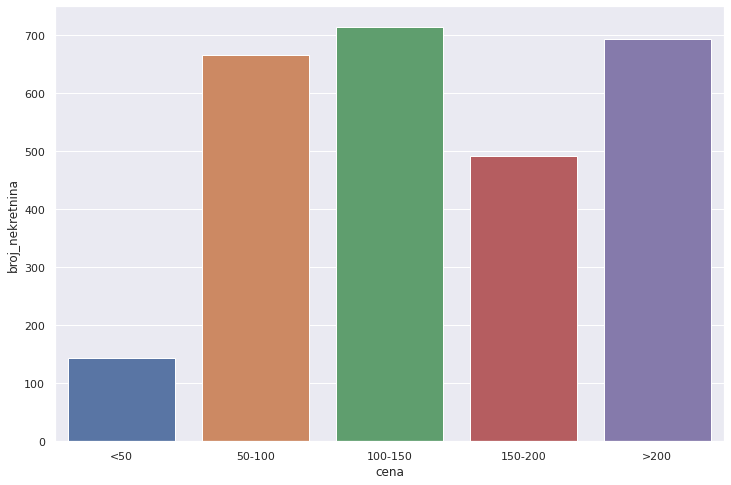

In [6]:
groups = pd.read_csv('./podaci/ready_data_odbrana.csv', lineterminator='\n', header='infer')
groups=groups.groupby(pd.cut(groups['cena'], bins=bins, labels=labels)).size().reset_index(name='broj_nekretnina')

figure(figsize=(12, 8))
sns.barplot(x=groups['cena'], y=groups['broj_nekretnina'])

In [7]:
features = pd.get_dummies(df.drop('cena', axis=1))

## Skaliranje numerickih promenljivih

In [8]:
scaler = StandardScaler()

scaler.fit(features[['povrsina', 'udaljenost_od_centra']])
scaled_features = scaler.transform(features[['povrsina', 'udaljenost_od_centra']])
features.povrsina, features.udaljenost_od_centra = scaled_features[:, 0], scaled_features[:, 1]

In [9]:
features

,povrsina,udaljenost_od_centra,grejanje_TA peć,grejanje_centralno grejanje,grejanje_etažno grejanje,grejanje_grejanje na gas,grejanje_grejanje na struju,grejanje_kaljeva peć,grejanje_norveški radijatori,grejanje_podno grejanje,...,spratnost_4,spratnost_5,spratnost_6,spratnost_7,spratnost_>7,spratnost_potkrovlje,spratnost_prizemlje,spratnost_suteren,infrastruktura_ima,infrastruktura_nema
0,-0.683886,-0.303323,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2.165563,-0.090072,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.715397,-1.019596,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.936590,-0.560431,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,-0.124173,-1.421031,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,-0.531237,-0.998946,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2704,-0.327705,0.139483,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2705,-1.040068,1.633519,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2706,-0.734769,-0.168358,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


# Predikcija - euklidska distanca

### Treniranje modela koriscenjem hot-encoded odlika - los rezultat - manje bitne odlike imaju veliki uticaj

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(features, df['cena'], test_size=0.30, random_state=421)

In [11]:
def plot_error_against_k(_knn=KNeighborsClassifier, _metric='euclidean'):
    error_rate = []
    for i in range(1,20):
        knn = _knn(n_neighbors=i, metric=_metric)
        knn.fit(xtrain,ytrain)
        pred_i = knn.predict(xtest)
        error_rate.append(np.mean(pred_i != ytest))

    plt.figure(figsize=(10,6))
    plt.plot(range(1, 20),error_rate,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

In [12]:
from sklearn.metrics import classification_report,confusion_matrix
def classify_and_report(_knn=KNeighborsClassifier,_metric='euclidean', n_neigh = 1):
    knn = _knn(n_neighbors=n_neigh, metric=_metric)
    knn.fit(xtrain,ytrain)
    pred = knn.predict(xtest)
    print(confusion_matrix(ytest,pred))
    print(classification_report(ytest,pred))

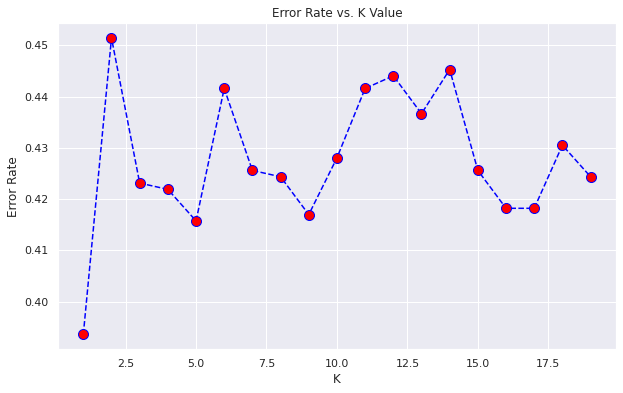

In [13]:
plot_error_against_k()

In [14]:
classify_and_report(n_neigh=1)

[[123  27  33   2   8]
 [ 41  72  13   0  27]
 [ 48   8 112  17   0]
 [  3   2  33  15   0]
 [ 13  41   4   0 171]]
              precision    recall  f1-score   support

     100-150       0.54      0.64      0.58       193
     150-200       0.48      0.47      0.48       153
      50-100       0.57      0.61      0.59       185
         <50       0.44      0.28      0.34        53
        >200       0.83      0.75      0.79       229

    accuracy                           0.61       813
   macro avg       0.57      0.55      0.56       813
weighted avg       0.61      0.61      0.61       813



### Treniranje modela bez kategorickih odlika - bolji rezultat

In [15]:
numeric_features = features[['povrsina', 'udaljenost_od_centra']]

#### Podela skupa po povrsini i udaljenosti od centra

/home/upflo/fakultet/psz/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


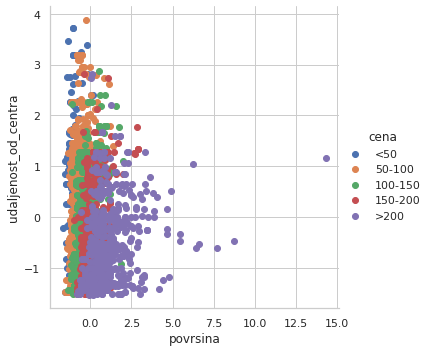

In [16]:
temp = numeric_features.copy()
temp['cena'] = df['cena']
sns.set_style('whitegrid')
sns.FacetGrid(temp, hue='cena', size=5).map(plt.scatter, 'povrsina', 'udaljenost_od_centra').add_legend()
plt.show()

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(numeric_features, df['cena'], test_size=0.30, random_state=421)

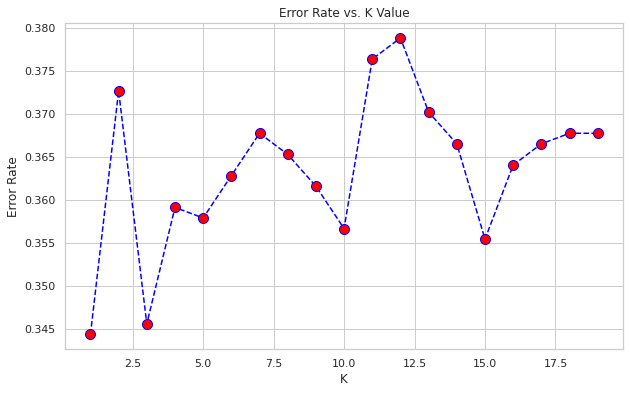

In [18]:
plot_error_against_k()

## Rezultat

In [19]:
classify_and_report(n_neigh=3)

[[133  22  31   0   7]
 [ 50  71   3   0  29]
 [ 44   6 124  11   0]
 [  8   1  20  24   0]
 [ 21  26   2   0 180]]
              precision    recall  f1-score   support

     100-150       0.52      0.69      0.59       193
     150-200       0.56      0.46      0.51       153
      50-100       0.69      0.67      0.68       185
         <50       0.69      0.45      0.55        53
        >200       0.83      0.79      0.81       229

    accuracy                           0.65       813
   macro avg       0.66      0.61      0.63       813
weighted avg       0.67      0.65      0.65       813



# Predikcija - manhattan distanca

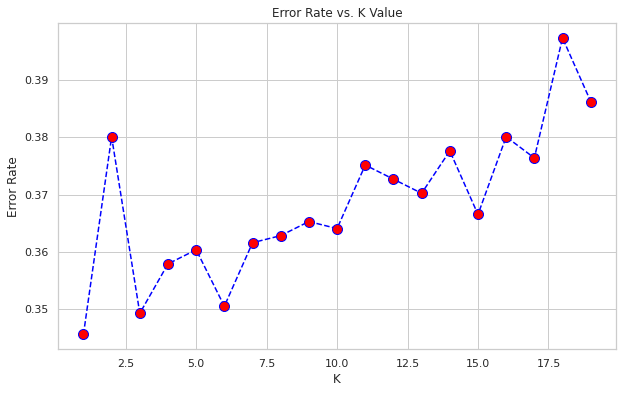

In [20]:
plot_error_against_k(_metric='manhattan')

## Rezultat

In [21]:
classify_and_report(n_neigh=6, _metric='manhattan')

[[136  25  26   0   6]
 [ 53  70   3   0  27]
 [ 43   6 130   6   0]
 [  4   1  29  19   0]
 [ 16  38   1   1 173]]
              precision    recall  f1-score   support

     100-150       0.54      0.70      0.61       193
     150-200       0.50      0.46      0.48       153
      50-100       0.69      0.70      0.70       185
         <50       0.73      0.36      0.48        53
        >200       0.84      0.76      0.80       229

    accuracy                           0.65       813
   macro avg       0.66      0.60      0.61       813
weighted avg       0.66      0.65      0.65       813



## Baseline - izlaz je najfrekventnija klasa

In [22]:
ybaseline = ['100-150'] * len(ytest)
baseline_most_freq_class = accuracy_score(ytest, ybaseline)
baseline_most_freq_class

0.23739237392373924

## Baseline - izlaz je random klasa

In [23]:
knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn.fit(xtrain,ytrain)
ypred = knn.predict(xtest)
np.random.shuffle(ypred)

baseline_random = accuracy_score(ytest, ypred)
baseline_random

0.24969249692496925

# Moja implementacija algoritma

In [24]:
def euclidean_distance(vector1,vector2):
    return math.sqrt(sum((val1 - val2)**2 for val1, val2 in zip(vector1,vector2)))

In [25]:
def manhattan(vector1, vector2):
    return sum(abs(val1-val2) for val1, val2 in zip(vector1,vector2))

In [26]:
from collections import Counter

class MyKNN():
    def __init__(self, k=3, distance_metric=euclidean_distance):
        self.k = k
        self.distance_metric = distance_metric

    def _vote(self, neighbor_labels):
        counter = Counter(neighbor_labels)
        return counter.most_common(1)[0][0]

    def predict(self, xtest, xtrain, ytrain):
        ypred = [''] * xtest.shape[0]
        for i, test_sample in enumerate(xtest):
            idx = np.argsort([self.distance_metric(test_sample, x) for x in xtrain])[:self.k]
            k_nearest_neighbors = np.array([ytrain[i] for i in idx])
            ypred[i] = self._vote(k_nearest_neighbors)
        return ypred

## Euklidska distanca

In [27]:
myknn = MyKNN(k=3)
ypred = myknn.predict(np.asarray(xtest),np.asarray(xtrain),np.asarray(ytrain))

## Rezultat

In [28]:
print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))

[[124  25  36   0   8]
 [ 39  77   5   0  32]
 [ 36   8 126  14   1]
 [  4   1  20  28   0]
 [ 15  27   3   0 184]]
              precision    recall  f1-score   support

     100-150       0.57      0.64      0.60       193
     150-200       0.56      0.50      0.53       153
      50-100       0.66      0.68      0.67       185
         <50       0.67      0.53      0.59        53
        >200       0.82      0.80      0.81       229

    accuracy                           0.66       813
   macro avg       0.65      0.63      0.64       813
weighted avg       0.66      0.66      0.66       813



## Manhattan distanca

In [29]:
myknn = MyKNN(k=6, distance_metric=manhattan)
ypred = myknn.predict(np.asarray(xtest),np.asarray(xtrain),np.asarray(ytrain))

## Rezultat

In [30]:
print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))

[[126  30  28   0   9]
 [ 46  66   3   0  38]
 [ 33   5 138   8   1]
 [  3   1  26  23   0]
 [ 14  27   1   1 186]]
              precision    recall  f1-score   support

     100-150       0.57      0.65      0.61       193
     150-200       0.51      0.43      0.47       153
      50-100       0.70      0.75      0.72       185
         <50       0.72      0.43      0.54        53
        >200       0.79      0.81      0.80       229

    accuracy                           0.66       813
   macro avg       0.66      0.62      0.63       813
weighted avg       0.66      0.66      0.66       813

